<a href="https://colab.research.google.com/github/ZhuWenjie98/FreMix/blob/main/FreMix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import random
import numpy as np
import os
import cv2
from PIL import Image

In [7]:
T1 = transforms.Resize((224,224))
T2 = transforms.Resize((224,224))

In [49]:
img_cat = Image.open('cat.jpeg')
img_dog = Image.open('dog.jpeg')
img_cat = T1(img_cat)
img_dog = T2(img_dog)

In [50]:
print(img_cat.size)

(224, 224)


In [51]:
img_cat = np.array(img_cat)
img_dog = np.array(img_dog)

In [112]:
def colorful_spectrum_mix(img1, img2, lam, ratio):
    """Input image size: ndarray of [1, C, H, W]"""
    #lam = np.random.uniform(0, alpha)
    #assert img1.shape == img2.shape
    print(lam)
    print(ratio)
    h, w, c  = img1.shape
    lam = torch.tensor(lam).cuda()
    ratio = torch.tensor(ratio, dtype=torch.float).cuda()
    h_crop = int(h * torch.sqrt(ratio))
    w_crop = int(w * torch.sqrt(ratio))
    
    h_start = h // 2 - h_crop // 2
    w_start = w // 2 - w_crop // 2
   

    img1_fft = torch.fft.fft2(img1, dim=(0,1))
    img2_fft = torch.fft.fft2(img2, dim=(0,1))
    img1_abs, img1_pha = torch.abs(img1_fft).cuda(), torch.angle(img1_fft).cuda()
    img2_abs, img2_pha = torch.abs(img2_fft).cuda(), torch.angle(img2_fft).cuda()

    img1_abs = torch.fft.fftshift(img1_abs.cuda(), dim=(0, 1)).cuda()
    img2_abs = torch.fft.fftshift(img2_abs.cuda(), dim=(0, 1)).cuda()

    img1_abs_ = torch.clone(img1_abs).cuda()
    img2_abs_ = torch.clone(img2_abs).cuda()
    ## phase1 + lam * amp2 + (1-lam) * amp1

    img1_abs[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img1_abs_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img2_abs_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]
    ## phase2 + lam * amp1 + (1-lam) * amp2
    img2_abs[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img2_abs_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img1_abs_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]
                                                                                        
    img1_abs = torch.fft.ifftshift(img1_abs.cuda(), dim=(0, 1))
    img2_abs = torch.fft.ifftshift(img2_abs.cuda(), dim=(0, 1))
    
    
    img21 = img1_abs * (np.e ** (1j * img1_pha))
    img12 = img2_abs * (np.e ** (1j * img2_pha))
    img21 = torch.real(torch.fft.ifft2(img21,dim=(0, 1)))
    img12 = torch.real(torch.fft.ifft2(img12,dim=(0, 1)))
    img21 = torch.clip(img21, 0, 255).int()
    img12 = torch.clip(img12, 0, 255).int()
    
    
    return img21, img12

In [136]:
def frequency_spectrum_mix(img1, img2, alpha, ratio=1.0):
    """Input image size: ndarray of [C, H, W]"""
    lam = torch.tensor(alpha).cuda()
    ratio = torch.tensor(ratio).cuda()
    h, w, c  = img1.shape
    ratio = torch.tensor(ratio, dtype=torch.float)
    h_crop = int(h * torch.sqrt(ratio))
    w_crop = int(w * torch.sqrt(ratio))

    h_start = h // 2 - h_crop // 2
    w_start = w // 2 - w_crop // 2

    img1_fft = torch.fft.fft2(img1, dim=(0,1))
    img2_fft = torch.fft.fft2(img2, dim=(0,1))
    img1_abs, img1_pha = torch.abs(img1_fft), torch.angle(img1_fft)
    img2_abs, img2_pha = torch.abs(img2_fft), torch.angle(img2_fft)

    img1_pha = torch.fft.fftshift(img1_pha, dim=(0, 1))
    img2_pha = torch.fft.fftshift(img2_pha, dim=(0, 1))

    img1_pha_ = torch.clone(img1_pha)
    img2_pha_ = torch.clone(img2_pha)

    img1_pha_ = torch.Tensor(img1_pha_).cuda()
    img2_pha_ = torch.Tensor(img2_pha_).cuda()
    ## amp1 + lam * phase1 + (1-lam) * phase2
    img1_pha[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img1_pha_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img2_pha_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]
    ## amp2 + lam * phase2 + (1-lam) * phase1
    img2_pha[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img2_pha_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img1_pha_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]
    img1_pha = torch.fft.ifftshift(img1_pha, dim=(0, 1))
    img2_pha = torch.fft.ifftshift(img2_pha, dim=(0, 1))
    img21 = img1_abs * (np.e ** (1j * img1_pha)) 
    img12 = img2_abs * (np.e ** (1j * img2_pha))
    img21 = torch.real(torch.fft.ifft2(img21,dim=(0, 1)))
    img12 = torch.real(torch.fft.ifft2(img12,dim=(0, 1)))
    img21 = torch.clip(img21, 0, 255).int()
    img12 = torch.clip(img12, 0, 255).int()

    return img21, img12 

In [149]:
lam = np.random.beta(1, 1, 1).astype(np.float32)
# lam = np.ones(1)

In [150]:
print(lam)

[0.25371957]


In [151]:
print(1-lam)

[0.74628043]


In [113]:
img_cat, img_dog = torch.from_numpy(img_cat).cuda(), torch.from_numpy(img_dog).cuda()

TypeError: ignored

In [156]:
img_cat_amp_mix, img_dog_amp_mix = colorful_spectrum_mix(img_cat, img_dog, lam, 1-lam)

[0.25371957]
[0.74628043]


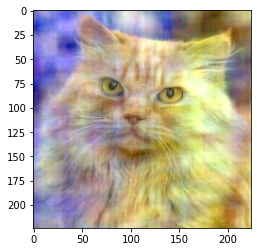

In [157]:
plt.imshow(img_cat_amp_mix.cpu())
plt.axis("on")
plt.show()

In [158]:
img_cat_phase_mix, img_dog_phase_mix = frequency_spectrum_mix(img_cat, img_dog, lam, 1-lam)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


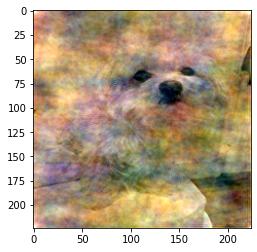

In [159]:
plt.imshow(img_cat_phase_mix.cpu())
plt.axis("on")
plt.show()